# Goal

Evaluate whether a pricing test running on the site has been successful.

*As always, you should focus on user segmentation and provide insights about segments who behave differently as well as any other insights you might find.

### *Description

The VP of Product has decided to run a test increasing the price. In the experiment, 66% of the users have seen the old price (\\$39), while a random sample of 33% users a higher price (\\$59). The test has been running for some time and the VP of Product is interested in understanding how it went and whether it would make sense to increase the price for all the users.

### *Tasks

1. Should the company sell its software for \\$39 or \\$59?


2. The VP of Product is interested in having a holistic view into user behavior, especially focusing on actionable insights that might increase conversion rate. What are your main findings looking at the data?


[Bounus] 3. The VP of Product feels that the test has been running for too long and they should have been able to get statistically significant results in a shorter time. Do you agree with this? After how many days you would have stopped the test? Please, explain why.

# Solution

### 1. Load data

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
%matplotlib inline
#This is only for jupyter notebooks, if you are using another editor, you'll use: plt.show() at the end of all your plotting commands to have the figure pop up in another window.

In [2]:
#read data
test_results = pd.read_csv("./Pricing_Test/test_results.csv")
user = pd.read_csv("./Pricing_Test/user_table.csv")

In [3]:
print(test_results.head())

   user_id            timestamp          source  device operative_system  \
0   604839  2015-05-08 03:38:34    ads_facebook  mobile              iOS   
1   624057  2015-05-10 21:08:46      seo-google  mobile          android   
2   317970  2015-04-04 15:01:23        ads-bing  mobile          android   
3   685636  2015-05-07 07:26:01  direct_traffic  mobile              iOS   
4   820854  2015-05-24 11:04:40    ads_facebook     web              mac   

   test  price  converted  
0     0     39          0  
1     0     39          0  
2     0     39          0  
3     1     59          0  
4     0     39          0  


In [4]:
print(user.head())

   user_id         city country    lat    long
0   510335      Peabody     USA  42.53  -70.97
1    89568         Reno     USA  39.54 -119.82
2   434134       Rialto     USA  34.11 -117.39
3   289769  Carson City     USA  39.15 -119.74
4   939586      Chicago     USA  41.84  -87.68


In [5]:
#check null value
test_results.isnull().sum()

user_id             0
timestamp           0
source              0
device              0
operative_system    0
test                0
price               0
converted           0
dtype: int64

In [6]:
#check null value
user.isnull().sum()

user_id    0
city       0
country    0
lat        0
long       0
dtype: int64

In [7]:
#check uniqueness of user_id in test_results table
print(test_results['user_id'].nunique() == len(test_results['user_id']))

True


In [8]:
#check uniqueness of user_id in user table
print(user['user_id'].nunique() == len(user['user_id']))

True


### 2. Data Processing

In [9]:
#join test_results table and user table based on user_id
data = pd.merge(left=test_results, right=user, how='left', on='user_id')
print(data.head())

   user_id            timestamp          source  device operative_system  \
0   604839  2015-05-08 03:38:34    ads_facebook  mobile              iOS   
1   624057  2015-05-10 21:08:46      seo-google  mobile          android   
2   317970  2015-04-04 15:01:23        ads-bing  mobile          android   
3   685636  2015-05-07 07:26:01  direct_traffic  mobile              iOS   
4   820854  2015-05-24 11:04:40    ads_facebook     web              mac   

   test  price  converted          city country    lat   long  
0     0     39          0       Buffalo     USA  42.89 -78.86  
1     0     39          0     Lakeville     USA  44.68 -93.24  
2     0     39          0         Parma     USA  41.38 -81.73  
3     1     59          0  Fayetteville     USA  35.07 -78.90  
4     0     39          0       Fishers     USA  39.95 -86.02  


In [10]:
#check null value
data.isnull().sum()

user_id                 0
timestamp               0
source                  0
device                  0
operative_system        0
test                    0
price                   0
converted               0
city                41184
country             41184
lat                 41184
long                41184
dtype: int64

In [11]:
data[['test','price','user_id']].groupby(['test','price']).count()

user_id
test price         
0    39      202517
     59         210
1    39         155
     59      113918

There are some problems with the data: there are 210 users saw the new price in control group while 155 users didn't see the new price in test group. Because just a small portion of data is problematic, we can simply delete them.

In [12]:
data = data[((data['test']==0) & (data['price']==39)) | ((data['test']==1) & (data['price']==59))]
data[['test','price','user_id']].groupby(['test','price']).count()

,,user_id
test,price,
0,39,202517
1,59,113918


In [13]:
#create a new variable called revenue
data['revenue'] = data['converted'] * data['price']
data.head()

,user_id,timestamp,source,device,operative_system,test,price,converted,city,country,lat,long,revenue
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0,Buffalo,USA,42.89,-78.86,0
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0,Lakeville,USA,44.68,-93.24,0
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0,Parma,USA,41.38,-81.73,0
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0,Fayetteville,USA,35.07,-78.90,0
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0,Fishers,USA,39.95,-86.02,0


### 3. Check A/B test randomiazation

A crucial assumption behind an A/B test is that the only difference between test and control has to be the feature we are testing. It is therefore extremely important to check that test and control distributions are similar before doing the statistical test. Checking that randomization worked well simply means making sure that all variables have the ***same distribution in test and control***.

a) By source

In [14]:
data_grouped_source = data.groupby('source')['test'].agg([('frequency_test_0', lambda x : len(x[x==0])),
                                                          ('frequency_test_1', lambda x : len(x[x==1]))])
print(data_grouped_source/data_grouped_source.sum())

                 frequency_test_0  frequency_test_1
source                                             
ads-bing                 0.072014          0.072394
ads-google               0.186873          0.188706
ads-yahoo                0.023761          0.024219
ads_facebook             0.168253          0.169253
ads_other                0.095083          0.092786
direct_traffic           0.191154          0.189259
friend_referral          0.064790          0.066337
seo-bing                 0.006562          0.007154
seo-google               0.074502          0.070753
seo-other                0.029030          0.029539
seo-yahoo                0.021509          0.021814
seo_facebook             0.066468          0.067786


b) By device

In [15]:
data_grouped_device = data.groupby('device')['test'].agg([('frequency_test_0', lambda x : len(x[x==0])),
                                                          ('frequency_test_1', lambda x : len(x[x==1]))])
print(data_grouped_device/data_grouped_device.sum())

        frequency_test_0  frequency_test_1
device                                    
mobile          0.594365          0.578469
web             0.405635          0.421531


c) By operative system

In [16]:
data_grouped_os = data.groupby('operative_system')['test'].agg([('frequency_test_0', lambda x : len(x[x==0])),
                                                          ('frequency_test_1', lambda x : len(x[x==1]))])
print(data_grouped_os/data_grouped_os.sum())

                  frequency_test_0  frequency_test_1
operative_system                                    
android                   0.237891          0.234318
iOS                       0.305125          0.294598
linux                     0.010883          0.016907
mac                       0.080709          0.076459
other                     0.051754          0.050001
windows                   0.313638          0.327718


### Question 1

In [21]:
data[['test','revenue']].groupby('test').mean('revenue')

,revenue
test,
0,0.776083
1,0.917748


The average revenue for higher price (\\$59) is higher than the average revenue for old price (\\$39), the difference is around \\$0.142. Now let's conduct a hypothesis test to check if the difference is significant.

H0: The average revenue for higher price <= the average revenue for old price;
H1: The average revenue for higher price > the average revenue for old price

In [66]:
from scipy.stats import ttest_ind
ttest_ind(data[data['test']==0]['revenue'].values, data[data['test']==1]['revenue'].values, equal_var = False).pvalue/2 < 0.05

True

We reject H0, and so the average revenue for higher price is significantly higher than the average revenue for old price. So the company can get higher revenue if it sells its software for \\$59.

# Question 2

Let's calculate the conversion rate

a) By source

In [58]:
data.groupby('source')['converted'].mean().reset_index()

,source,converted
0,ads-bing,0.012001
1,ads-google,0.021502
2,ads-yahoo,0.014793
3,ads_facebook,0.021198
4,ads_other,0.014350
5,direct_traffic,0.012294
6,friend_referral,0.038688
7,seo-bing,0.023787
8,seo-google,0.016978
9,seo-other,0.015686


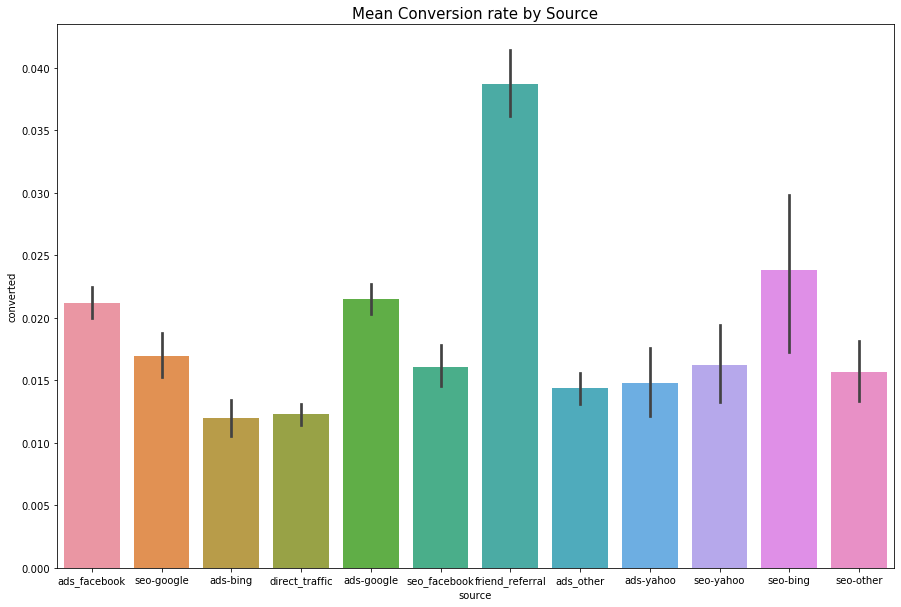

In [57]:
fig, axes = plt.subplots(figsize=(15, 10))
sns.barplot(x='source',y='converted',data=data)
axes.set_title("Mean Conversion rate by Source", fontsize = 15)
plt.show()

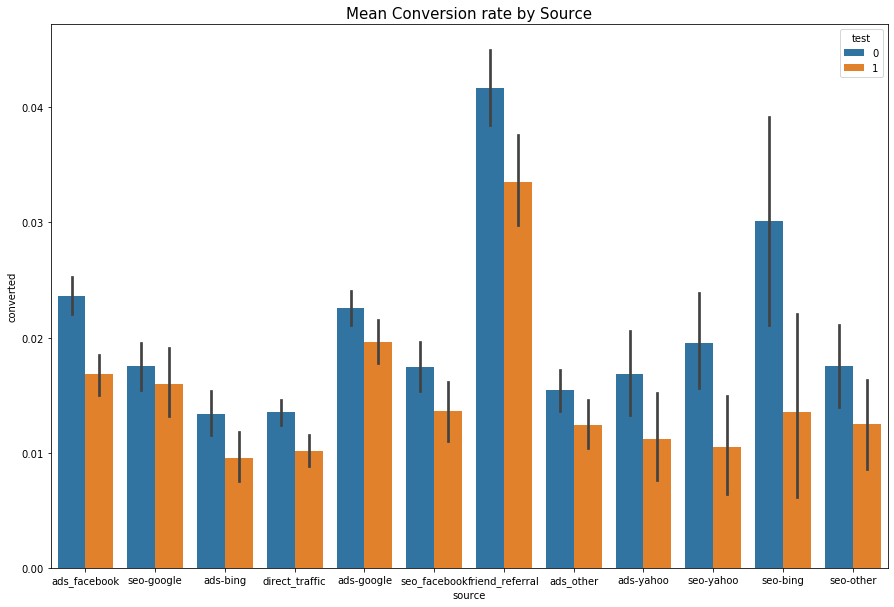

In [56]:
fig, axes = plt.subplots(figsize=(15, 10))
sns.barplot(x='source',y='converted', hue='test',data=data)
axes.set_title("Mean Conversion rate by Source", fontsize = 15)
plt.show()

b) By device

In [59]:
data.groupby('device')['converted'].mean().reset_index()

,device,converted
0,mobile,0.018554
1,web,0.018023


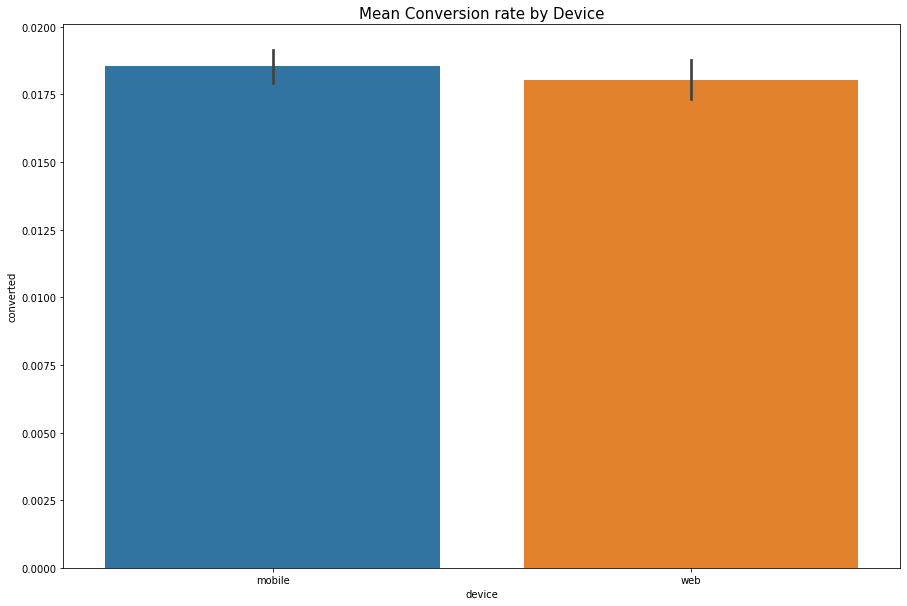

In [60]:
fig, axes = plt.subplots(figsize=(15, 10))
sns.barplot(x='device',y='converted',data=data)
axes.set_title("Mean Conversion rate by Device", fontsize = 15)
plt.show()

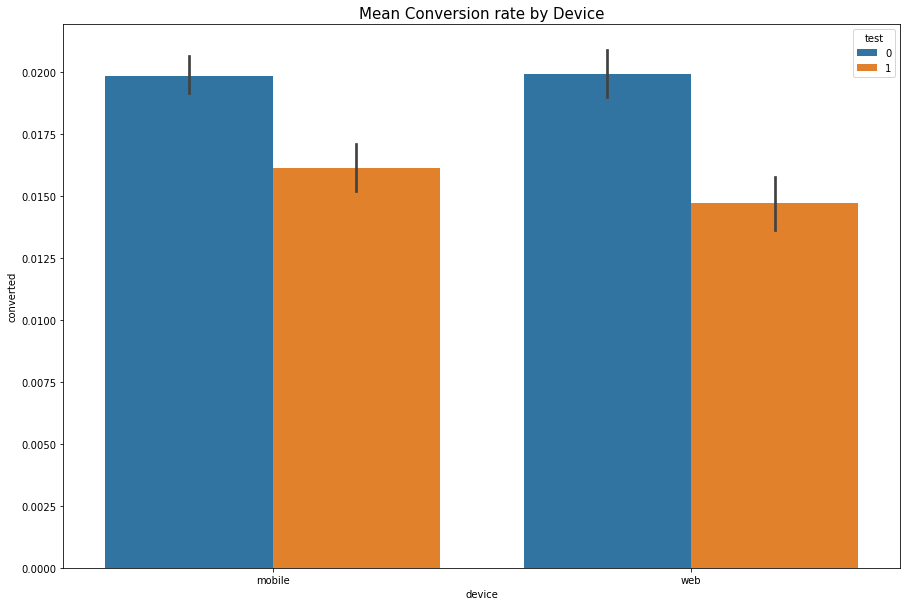

In [61]:
fig, axes = plt.subplots(figsize=(15, 10))
sns.barplot(x='device',y='converted', hue='test',data=data)
axes.set_title("Mean Conversion rate by Device", fontsize = 15)
plt.show()

c) By operative system

In [62]:
data.groupby('operative_system')['converted'].mean().reset_index()

,operative_system,converted
0,android,0.014919
1,iOS,0.022328
2,linux,0.008232
3,mac,0.023987
4,other,0.012981
5,windows,0.016966


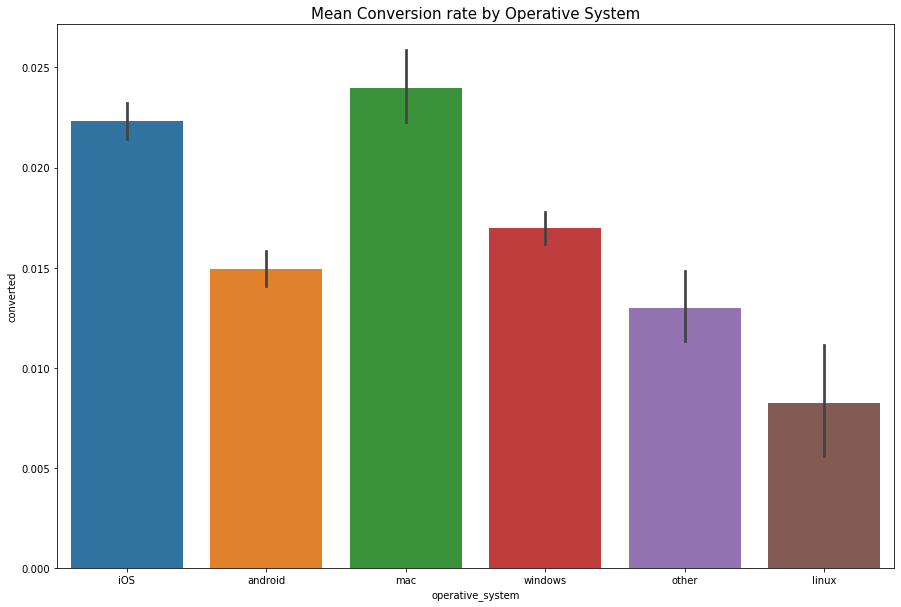

In [63]:
fig, axes = plt.subplots(figsize=(15, 10))
sns.barplot(x='operative_system',y='converted',data=data)
axes.set_title("Mean Conversion rate by Operative System", fontsize = 15)
plt.show()

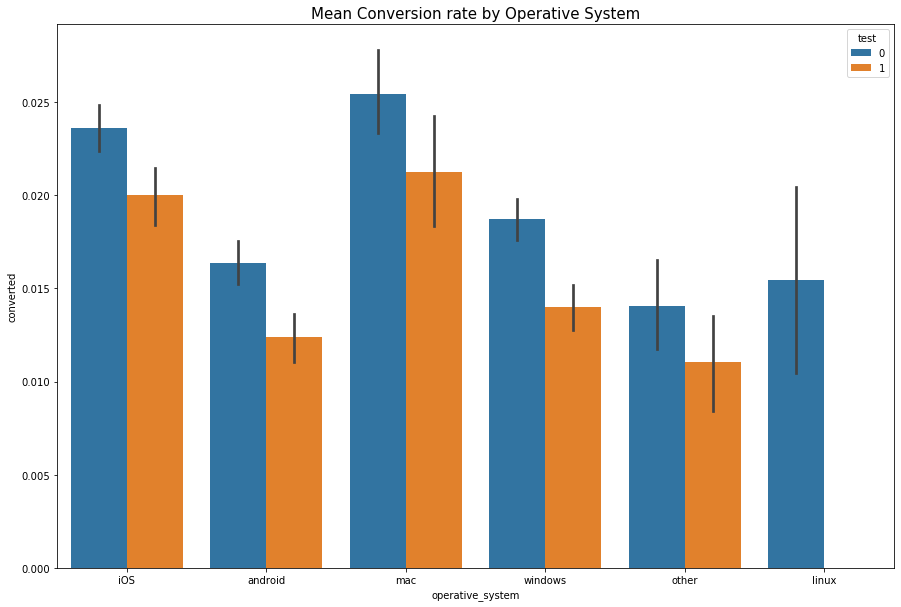

In [64]:
fig, axes = plt.subplots(figsize=(15, 10))
sns.barplot(x='operative_system',y='converted',hue='test',data=data)
axes.set_title("Mean Conversion rate by Operative System", fontsize = 15)
plt.show()

We can see that users come from friend referral and users use iOS or mac operative system have higher conversion rate. Users in control group (old price) have higher conversion rate than users in test group (higher price).

Reference: https://github.com/JifuZhao/DS-Take-Home/blob/master/06.%20Pricing%20Test.ipynb